# Target

1. Establish an error-free, working code. 

2. Build the data pipeline from data ingestion, transforms, data loader and train and test loop functions. 

3. Build a simple model focussing primarily on Convolution layers.

4. Do not worry about model size or overfitting. Try to fit the data well and achieve good training accuracy. 

# Results

Total Parameters: 62894

Best Training Accuracy: 99.50

Best Test Accuracy: 99.01

# Analysis

1. The model fits the data well but it is too big (62k parameters)

2. The training accuracy outperforms test accuracy significantly indicating overfitting. 

3. We will use Max Pooling and (1X1) Convolutions in next Notebook to ensure the most relevant features are carried forward in the network and the model is reasonable. This has 2 benefits:

  1. Reduce Overfitting by not carrying forward noise deep in the network

  2. Making the model lighter (lesser parameters)

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
%matplotlib inline
import matplotlib.pyplot as plt

In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


In [0]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)




CUDA Available? True


In [0]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.cnn_layers = Sequential(
            # Defining a 2D convolution layer
            Conv2d(1, 16, kernel_size=3, padding=0),
            ReLU(inplace=True),

            Conv2d(16, 16, kernel_size=3, padding=0),
            ReLU(inplace=True),

            Conv2d(16, 32, kernel_size=3, padding=0),
            ReLU(inplace=True),      

            Conv2d(32, 32, kernel_size=3, padding=0),
            ReLU(inplace=True),

            Conv2d(32, 64, kernel_size=3, padding=0),
            ReLU(inplace=True),

            MaxPool2d(kernel_size=2),  

            Conv2d(64, 32, kernel_size=3, padding=0),
            ReLU(inplace=True),                                
            
            Conv2d(32, 16, kernel_size=3, padding=0),
            ReLU(inplace=True),

            Conv2d(16, 12, kernel_size=5, padding=0),
            ReLU(inplace=True),

            Conv2d(12, 10, kernel_size=1)

        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = x.view(-1, 10)
        return F.log_softmax(x)

In [0]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             160
              ReLU-2           [-1, 16, 26, 26]               0
            Conv2d-3           [-1, 16, 24, 24]           2,320
              ReLU-4           [-1, 16, 24, 24]               0
            Conv2d-5           [-1, 32, 22, 22]           4,640
              ReLU-6           [-1, 32, 22, 22]               0
            Conv2d-7           [-1, 32, 20, 20]           9,248
              ReLU-8           [-1, 32, 20, 20]               0
            Conv2d-9           [-1, 64, 18, 18]          18,496
             ReLU-10           [-1, 64, 18, 18]               0
        MaxPool2d-11             [-1, 64, 9, 9]               0
           Conv2d-12             [-1, 32, 7, 7]          18,464
             ReLU-13             [-1, 32, 7, 7]               0
           Conv2d-14             [

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [0]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 16
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=0.5164729952812195 Batch_id=468 Accuracy=35.40: 100%|██████████| 469/469 [00:13<00:00, 34.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.3183, Accuracy: 9034/10000 (90.34%)

EPOCH: 1


Loss=0.09028851985931396 Batch_id=468 Accuracy=94.56: 100%|██████████| 469/469 [00:13<00:00, 34.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0927, Accuracy: 9712/10000 (97.12%)

EPOCH: 2


Loss=0.009519010782241821 Batch_id=468 Accuracy=97.53: 100%|██████████| 469/469 [00:13<00:00, 34.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0636, Accuracy: 9783/10000 (97.83%)

EPOCH: 3


Loss=0.06666835397481918 Batch_id=468 Accuracy=98.16: 100%|██████████| 469/469 [00:13<00:00, 34.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0504, Accuracy: 9850/10000 (98.50%)

EPOCH: 4


Loss=0.01694066822528839 Batch_id=468 Accuracy=98.49: 100%|██████████| 469/469 [00:13<00:00, 34.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0460, Accuracy: 9847/10000 (98.47%)

EPOCH: 5


Loss=0.021808451041579247 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:13<00:00, 34.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0372, Accuracy: 9884/10000 (98.84%)

EPOCH: 6


Loss=0.0035184721928089857 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:13<00:00, 34.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0340, Accuracy: 9897/10000 (98.97%)

EPOCH: 7


Loss=0.008767138235270977 Batch_id=468 Accuracy=98.95: 100%|██████████| 469/469 [00:13<00:00, 34.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0356, Accuracy: 9886/10000 (98.86%)

EPOCH: 8


Loss=0.01339811086654663 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:13<00:00, 34.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0441, Accuracy: 9852/10000 (98.52%)

EPOCH: 9


Loss=0.0014781554928049445 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:13<00:00, 33.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0282, Accuracy: 9901/10000 (99.01%)

EPOCH: 10


Loss=0.034084804356098175 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:13<00:00, 34.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0324, Accuracy: 9900/10000 (99.00%)

EPOCH: 11


Loss=0.011633495800197124 Batch_id=468 Accuracy=99.37: 100%|██████████| 469/469 [00:13<00:00, 34.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0342, Accuracy: 9888/10000 (98.88%)

EPOCH: 12


Loss=0.0029666125774383545 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:13<00:00, 34.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0339, Accuracy: 9897/10000 (98.97%)

EPOCH: 13


Loss=0.005522822495549917 Batch_id=468 Accuracy=99.43: 100%|██████████| 469/469 [00:13<00:00, 34.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0326, Accuracy: 9893/10000 (98.93%)

EPOCH: 14


Loss=0.026533713564276695 Batch_id=468 Accuracy=99.47: 100%|██████████| 469/469 [00:13<00:00, 34.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0326, Accuracy: 9896/10000 (98.96%)

EPOCH: 15


Loss=0.01624879240989685 Batch_id=468 Accuracy=99.50: 100%|██████████| 469/469 [00:13<00:00, 34.03it/s]



Test set: Average loss: 0.0352, Accuracy: 9905/10000 (99.05%)



Text(0.5, 1.0, 'Test Accuracy')

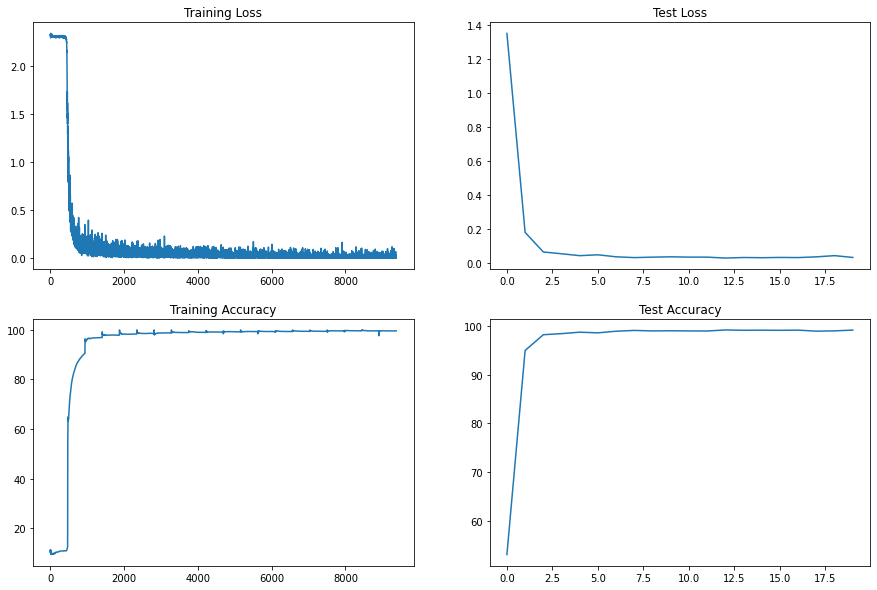

In [0]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")